# Deep learning Mini - project 1

## Author : Mostafa Bouziane - MVA



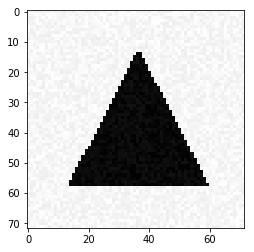

In [92]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

# On some implementations of matplotlib, you may need to change this value
IMAGE_SIZE = 72

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata

def generate_a_rectangle(noise=0.0, free_location=False):
    figsize = 1.0    
    U = np.zeros(4)
    V = np.zeros(4)
    if free_location:
        corners = np.random.random(4)
        top = max(corners[0], corners[1])
        bottom = min(corners[0], corners[1])
        left = min(corners[2], corners[3])
        right = max(corners[2], corners[3])
    else:
        side = (0.3 + 0.7 * np.random.random()) * figsize
        top = figsize/2 + side/2
        bottom = figsize/2 - side/2
        left = bottom
        right = top
    U[0] = U[1] = top
    U[2] = U[3] = bottom
    V[0] = V[3] = left
    V[1] = V[2] = right
    return generate_a_drawing(figsize, U, V, noise)


def generate_a_disk(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        center = np.random.random(2)
    else:
        center = (figsize/2, figsize/2)
    radius = (0.3 + 0.7 * np.random.random()) * figsize/2
    N = 50
    U = np.zeros(N)
    V = np.zeros(N)
    i = 0
    for t in np.linspace(0, 2*np.pi, N):
        U[i] = center[0] + np.cos(t) * radius
        V[i] = center[1] + np.sin(t) * radius
        i = i + 1
    return generate_a_drawing(figsize, U, V, noise)

def generate_a_triangle(noise=0.0, free_location=False):
    figsize = 1.0
    if free_location:
        U = np.random.random(3)
        V = np.random.random(3)
    else:
        size = (0.3 + 0.7 * np.random.random())*figsize/2
        middle = figsize/2
        U = (middle, middle+size, middle-size)
        V = (middle+size, middle-size, middle-size)
    imdata = generate_a_drawing(figsize, U, V, noise)
    return [imdata, [U[0], V[0], U[1], V[1], U[2], V[2]]]


im = generate_a_rectangle(10, True)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

im = generate_a_disk(10)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')

[im, v] = generate_a_triangle(20, False)
plt.imshow(im.reshape(IMAGE_SIZE,IMAGE_SIZE), cmap='gray')


def generate_dataset_classification(nb_samples, noise=0.0, free_location=False):
    # Getting im_size:
    im_size = generate_a_rectangle().shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros(nb_samples)
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i] = generate_a_disk(noise, free_location)
        else:
            [X[i], V] = generate_a_triangle(noise, free_location)
        Y[i] = category
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

def generate_test_set_classification():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_classification(300, 20, True)
    Y_test = keras.utils.to_categorical(Y_test, 3) 
    return [X_test, Y_test]

def generate_dataset_regression(nb_samples, noise=0.0):
    # Getting im_size:
    im_size = generate_a_triangle()[0].shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples, 6])
    print('Creating data:')
    for i in range(nb_samples):
        #if i % 10 == 0:
           ## print(i)
        [X[i], Y[i]] = generate_a_triangle(noise, True)
    X = (X + noise) / (255 + 2 * noise)
    return [X, Y]

import matplotlib.patches as patches

def visualize_prediction(x, y):
    fig, ax = plt.subplots(figsize=(5, 5))
    I = x.reshape((IMAGE_SIZE,IMAGE_SIZE))
    ax.imshow(I, extent=[-0.15,1.15,-0.15,1.15],cmap='gray')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])

    xy = y.reshape(3,2)
    tri = patches.Polygon(xy, closed=True, fill = False, edgecolor = 'r', linewidth = 5, alpha = 0.5)
    ax.add_patch(tri)

    plt.show()

def generate_test_set_regression():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_regression(300, 20)
    return [X_test, Y_test]

## Simple classification

In [2]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation,Convolution2D,MaxPooling2D,Flatten,BatchNormalization,Dropout
from sklearn.preprocessing import StandardScaler
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import UpSampling2D
from keras.models import Sequential, clone_model

C:\Users\Asus\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
[X_train, Y_train] = generate_dataset_classification(300, 20)
[X_test, Y_test] = generate_test_set_classification()

Creating data:
Creating data:


## Building the classifier for the image classification

### Building training model

In [8]:
Y_train_categorical = keras.utils.to_categorical(Y_train)
#Parameters
nb_of_classes = 3

#Create linear model
model =Sequential()

model.add(Dense(nb_of_classes,input_shape=(X_train.shape[1],),activation = 'softmax'))

print('Model training with Adam optimizer')
#Compile the model with the adam optimizer
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc']) 

#Fit the model
history= model.fit(X_train,Y_train_categorical,validation_data=(X_test,Y_test),epochs=20,batch_size=32)

print('Model training with SGD optimizer')
model1 =Sequential()

model1.add(Dense(nb_of_classes,input_shape=(X_train.shape[1],),activation = 'softmax'))
#Compile the model with the SGD optimizer
model1.compile(loss = 'categorical_crossentropy', optimizer = 'sgd',metrics=['acc']) 

#Fit the model
history= model1.fit(X_train,Y_train_categorical,validation_data=(X_test,Y_test),epochs=20,batch_size=32)

Model training with Adam optimizer
Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 332s 1s/step - loss: 1.6444 - acc: 0.3333 - val_loss: 1.7446 - val_acc: 0.2567
Epoch 2/20
300/300 [==============================] - 0s 407us/step - loss: 0.9377 - acc: 0.5500 - val_loss: 1.9824 - val_acc: 0.2200
Epoch 3/20
300/300 [==============================] - 0s 364us/step - loss: 0.6955 - acc: 0.6967 - val_loss: 1.9045 - val_acc: 0.3333
Epoch 4/20
300/300 [==============================] - 0s 377us/step - loss: 0.4828 - acc: 0.7733 - val_loss: 2.0266 - val_acc: 0.3000
Epoch 5/20
300/300 [==============================] - 0s 410us/step - loss: 0.3527 - acc: 0.8867 - val_loss: 1.8703 - val_acc: 0.2367
Epoch 6/20
300/300 [==============================] - 0s 451us/step - loss: 0.3572 - acc: 0.8267 - val_loss: 2.0220 - val_acc: 0.3033
Epoch 7/20
300/300 [==============================] - 0s 440us/step - loss: 0.2600 - acc: 0.9267 - val_loss: 2.0209 

### Evaluation of the model

In [12]:
print("Score of using Adam optimizer on the test set",model.evaluate(X_test,Y_test))
print("Score of using SGD optimizer on the test set",model1.evaluate(X_test,Y_test))

300/300 [==============================] - 0s 154us/step
Score on the test set [6.661888376871745, 0.3299999996026357]


**Comment** : The Adam optimizer seems to give better performances than SGD optimizer (train and test accuracy). The SGD can converge to Adam's performance if we reduce the learning rate to 0.0001 and with a bigger number of epochs.

## Visualization of the Solution

Text(0.5,1,'3rd column - triangle')

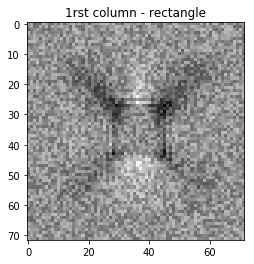

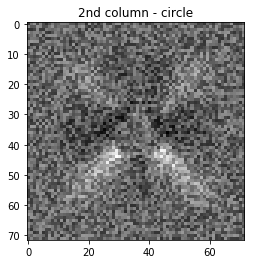

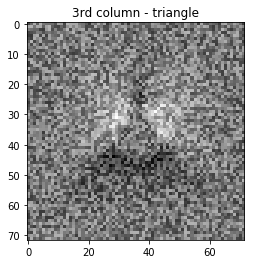

In [13]:
W,b = model.get_weights()
plt.figure(1)
plt.imshow(W[:,0].reshape(72,72), cmap='gray')
plt.title('1rst column - rectangle')



plt.figure(2)
plt.imshow(W[:,1].reshape(72,72), cmap='gray')
plt.title('2nd column - circle')


plt.figure(3)
plt.imshow(W[:,2].reshape(72,72), cmap='gray')
plt.title('3rd column - triangle')

**Comment** : The images above shows how the architecture deals with the features when assigning weights to detect each of the 3 figures (rectangle-circle-triangle). We can't see an intuitive explanation of the importance given to each part of the image ( apart from the rectangular form of the weight distribution for the rectangular class, and same thing with the triangular form of the weight distribution for the triangular class. 

## A more difficult classification problem

In [93]:
[X_train, Y_train] = generate_dataset_classification(1000, 20, True)
[X_test, Y_test] = generate_test_set_classification()

Y_train_categorical = keras.utils.to_categorical(Y_train)

X_train = X_train.reshape((-1,72,72,1))
X_test = X_test.reshape((-1,72,72,1))


Creating data:
Creating data:


In [10]:
#The simple architecture of the Mini-project
model =Sequential()

model.add(Convolution2D(16,kernel_size=(5,5),input_shape=(72,72,1,)))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dense(nb_of_classes,activation = 'softmax'))

#--------- Model specification and compiling------------# 
model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc']) 

history= model.fit(X_train,Y_train_categorical,validation_data=(X_test,Y_test),epochs=25,batch_size=32,verbose = False)

print('Score of the 1 convolutionnal model : ',model.evaluate(X_test, Y_test))
#I finally obtained about 95% accuracy with this last model

300/300 [==============================] - 1s 3ms/step
Score of the 1 convolutionnal model :  [0.38025581200917563, 0.8733333325386048]


**Comment** : We added more training data, and used a simple convolutionnal neural netwrok for our images classifications. As expected, the accuracy is much more important than the first simple architecture (87% on the test set). We can acheive a more important accuracy if we increase the training data.

In the next architecture, we propose to regularize the CNN using Drop out. We will see if it increases the accuracy.

In [98]:
model =Sequential()

model.add(Convolution2D(40,kernel_size=(5,5),input_shape=(72,72,1,)))
model.add(MaxPooling2D(pool_size=(3,3)))
model.add(Flatten())
model.add(Dropout(0.3))
model.add(Dense(3,activation = 'softmax'))

model.compile(loss = 'categorical_crossentropy', optimizer = 'adam',metrics=['acc']) 

model.fit(X_train,Y_train_categorical,validation_split=0.1,epochs=40,batch_size=32)


print('Regularized CNN score: ',model.evaluate(X_test, Y_test))


Train on 900 samples, validate on 100 samples
Epoch 1/40
900/900 [==============================] - 272s 303ms/step - loss: 1.0389 - acc: 0.4711 - val_loss: 0.8857 - val_acc: 0.5900
Epoch 2/40
900/900 [==============================] - 7s 7ms/step - loss: 0.7917 - acc: 0.6667 - val_loss: 0.7539 - val_acc: 0.7000
Epoch 3/40
900/900 [==============================] - 7s 7ms/step - loss: 0.6543 - acc: 0.7511 - val_loss: 0.6744 - val_acc: 0.7400
Epoch 4/40
900/900 [==============================] - 7s 7ms/step - loss: 0.5977 - acc: 0.7533 - val_loss: 0.7287 - val_acc: 0.6900
Epoch 5/40
900/900 [==============================] - 7s 7ms/step - loss: 0.5514 - acc: 0.8011 - val_loss: 0.6368 - val_acc: 0.7200
Epoch 6/40
900/900 [==============================] - 7s 7ms/step - loss: 0.5278 - acc: 0.7967 - val_loss: 0.6328 - val_acc: 0.7500
Epoch 7/40
900/900 [==============================] - 7s 7ms/step - loss: 0.4655 - acc: 0.8278 - val_loss: 0.6030 - val_acc: 0.8000
Epoch 8/40
900/900 [======

**Comment** : Adding regilarization to the model with 0.3 Dropout fraction, we increased the accuracy by 2% which is a good improvement of the last model.

##  A regression problem

**Experiment Set up** : For this part, we will try to train a regressor to predict the locations of the vertices of a triangle, for that, we will train a CNN architecture to evaluate results on the test datasets

Creating data:
Creating data:


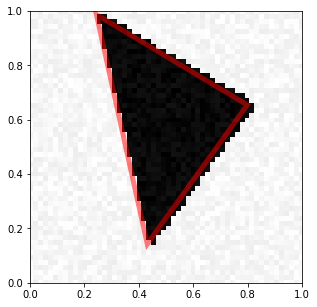

In [50]:
#Generate the datasets
[X_train, Y_train] = generate_dataset_regression(300, 20)
[X_test, Y_test] = generate_test_set_regression()
#Normalizing the data
normalizer = StandardScaler()
y_train_normalize = normalizer.fit_transform(Y_train)
y_test_normalize = normalizer.transform(Y_test)
X_train = X_train.reshape(300,72,72,1)
X_test = X_test.reshape(300,72,72,1)
visualize_prediction(X_train[0], Y_train[0])

In [36]:
def sorting(dataset, index):
    middle = 0.5
    res = np.zeros((300, 1))
    for i in range(0, 300):
        temp1 = [dataset[i,2*m]+dataset[i,2*m+1] for m in range(0, 3)]
        j = np.argmax(temp1)
        k = np.argmin(temp1)
        l = 3 - j - k
        temp2 = [dataset[i,2*j]-middle, dataset[i,2*j+1]-middle, 
                dataset[i,2*k]-middle, dataset[i,2*k+1]-middle, 
                dataset[i,2*l]-middle, dataset[i,2*l+1]-middle]
        res[i,:] = [temp2[index]]
    return res

In [38]:
Y_trainS = [sorting(Y_train, i) for i in range(0, 6)]
Y_testS = [sorting(Y_test, i) for i in range(0, 6)]

In [42]:
from keras.regularizers import l2, l1

### CNN architecture

**Experiment set-up**:  We will use 6 CNN architectures to predict for each coordinate of the vertices of the triangle. All the 6 architectures are the same using 32 filters of size 9x9, and 32 fully connected neurones, and Adam optimizer.

In [43]:
reg_param = 0.00001

model3 = Sequential()
model3.add(Conv2D(filters=32, kernel_size=(5,5), input_shape=(72,72,1), activation='relu', kernel_regularizer=l2(reg_param)))
model3.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_regularizer=l2(reg_param)))
# model3.add(Conv2D(filters=32, kernel_size=(2,2), activation='relu', kernel_regularizer=l2(reg_param)))
model3.add(Flatten())
model3.add(Dense(64, activation='relu', kernel_regularizer=l2(reg_param)))
model3.add(Dense(1))
# model3.add(Dense(6))
model3.compile(optimizer='adam', loss='mean_squared_error')
print(model3.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 68, 68, 32)        832       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 66, 66, 32)        9248      
_________________________________________________________________
flatten_7 (Flatten)          (None, 139392)            0         
_________________________________________________________________
dense_21 (Dense)             (None, 64)                8921152   
_________________________________________________________________
dense_22 (Dense)             (None, 1)                 65        
Total params: 8,931,297
Trainable params: 8,931,297
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
threshold = 0.05
errors = np.ones((6,2))
models = [clone_model(model3) for _ in range(0, 6)]
for i in range(0, 6):
    models[i] = clone_model(model3)
    models[i].compile(optimizer='adam', loss='mean_squared_error')
    models[i].fit(X_train, Y_trainS[i], validation_data=(X_test, Y_testS[i]), epochs=20, batch_size=64)
    train_error = models[i].evaluate(X_train, Y_trainS[i], verbose = 0)
    test_error = models[i].evaluate(X_test, Y_testS[i], verbose = 0)
    print("Evaluating model %i: train error %.3f - test error %.3f" % (i, train_error, test_error))

Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 342s 1s/step - loss: 331.3110 - val_loss: 11.2781
Epoch 2/20
300/300 [==============================] - 16s 53ms/step - loss: 3.7845 - val_loss: 0.6165
Epoch 3/20
300/300 [==============================] - 11s 37ms/step - loss: 0.2216 - val_loss: 0.0651
Epoch 4/20
300/300 [==============================] - 12s 39ms/step - loss: 0.0705 - val_loss: 0.0745
Epoch 5/20
300/300 [==============================] - 11s 38ms/step - loss: 0.0703 - val_loss: 0.0646
Epoch 6/20
300/300 [==============================] - 11s 36ms/step - loss: 0.0602 - val_loss: 0.0642
Epoch 7/20
300/300 [==============================] - 12s 39ms/step - loss: 0.0548 - val_loss: 0.0661
Epoch 8/20
300/300 [==============================] - 12s 38ms/step - loss: 0.0493 - val_loss: 0.0658
Epoch 9/20
300/300 [==============================] - 12s 40ms/step - loss: 0.0433 - val_loss: 0.0663
Epoch 10/20
300/300 [=============

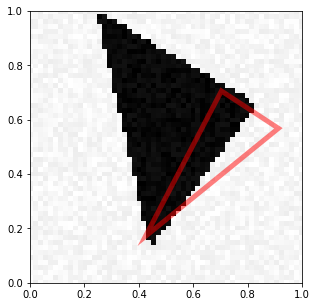

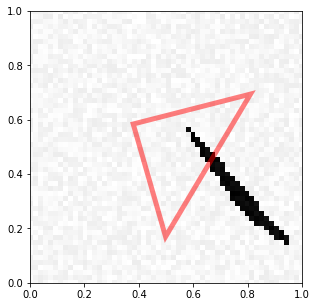

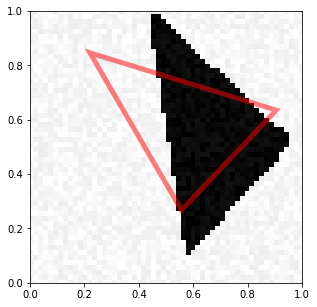

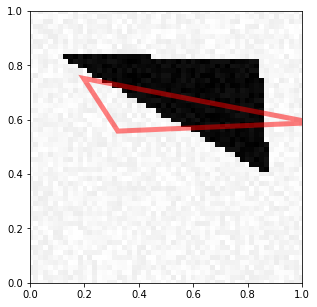

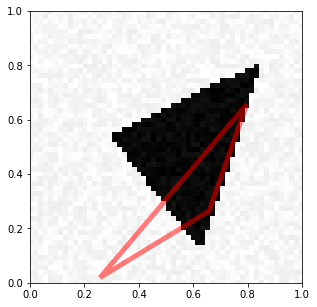

In [63]:
for i in range(0,5):
    predictions = np.array([models[k].predict(X_train)[i,0]+0.5 for k in range(0,6)])
    visualize_prediction(X_train[i,:,:], predictions)

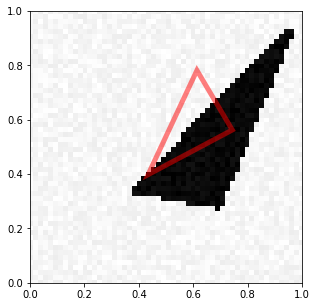

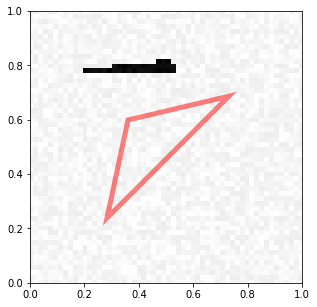

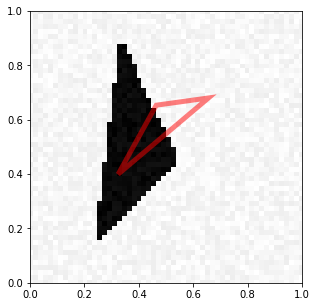

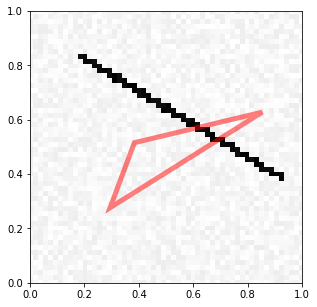

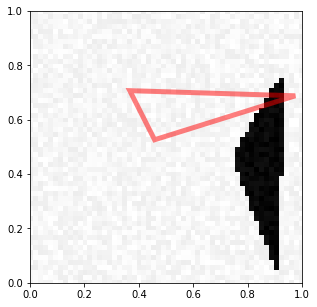

In [62]:
for i in range(0,5):
    predictions = np.array([models[k].predict(X_test)[i,0]+0.5 for k in range(0,6)])
    visualize_prediction(X_test[i,:,:], predictions)

**Comment** : We see that the trai and test error for each coordinates are around (0.03 for train , and 0.07 for test) which is quiet a good performance comparing to using a simple regression model directly on the coordinates (where we got at best 0.92 in loss).

The results of plotting the predictions seems to be converging to the right solution, but needs more training data, and a more complex architecture to converge correctly.

## Image denoising

We will modify the data generating functions, so that the output of each funtion could be, the image and its noisy version for our denoising task

In [3]:

def generate_a_drawing(figsize, U, V, noise=0.0):
    fig = plt.figure(figsize=(figsize,figsize))
    ax = plt.subplot(111)
    plt.axis('Off')
    ax.set_xlim(0,figsize)
    ax.set_ylim(0,figsize)
    ax.fill(U, V, "k")
    fig.canvas.draw()
    imdata = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)[::3].astype(np.float32)
    imdata_noise = imdata + noise * np.random.random(imdata.size)
    plt.close(fig)
    return imdata_noise,imdata

def generate_dataset_noise(nb_samples, free_location=False):
    # Getting im_size:
    im_size = (generate_a_rectangle()[0]).shape[0]
    X = np.zeros([nb_samples,im_size])
    Y = np.zeros([nb_samples,im_size])
    print('Creating data:')
    for i in range(nb_samples):
        noise = np.random.randint(10,100)
        #if i % 10 == 0:
            #print(i)
        category = np.random.randint(3)
        if category == 0:
            X[i],Y[i] = generate_a_rectangle(noise, free_location)
        elif category == 1: 
            X[i],Y[i] = generate_a_disk(noise, free_location)
        else:
            output = generate_a_triangle(noise, free_location)
            X[i],Y[i] = output[0]
    X = (X) / (255)
    Y = (Y)/(255)
    return [X, Y]


def generate_test_set_noise():
    np.random.seed(42)
    [X_test, Y_test] = generate_dataset_noise(300, 20)
    return [X_test, Y_test]    
 

In [82]:
X_train_noise,Y_train_noise = generate_dataset_noise(300) 
X_test_noise,Y_test_noise = generate_test_set_noise() 

Creating data:
Creating data:


In [83]:
Y_train_noise = Y_train_noise.astype('float32')
Y_test_noise = Y_test_noise.astype('float32')
Y_train_noise = np.reshape(Y_train_noise, (len(Y_train_noise), 72, 72, 1))  # adapt this if using `channels_first` image data format
Y_test_noise = np.reshape(Y_test_noise, (len(Y_test_noise), 72, 72, 1))  # adapt this if using `channels_first` image data format

X_train_noise = X_train_noise.astype('float32')
X_test_noise = X_test_noise.astype('float32')
X_train_noise = np.reshape(X_train_noise, (len(Y_train_noise), 72, 72, 1))  # adapt this if using `channels_first` image data format
X_test_noise = np.reshape(X_test_noise, (len(Y_test_noise), 72, 72, 1)) 

X_train_noise = np.clip(X_train_noise, 0., 1.)
X_test_noise = np.clip(X_test_noise, 0., 1.)

**Experiment**: We will use Autoencoders for denoising the images. The goal is to train the network to map noisy figures images to clean figures images. By learning a reconstruction of the noisy images given as inputs.

The architecture is composed of 2 convolutional layers for each the encoding and decoding parts. We use Adadelta optimizer for this task, as it appears that is the best one working for autoencoders in this task. 

In [67]:
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D
from keras.models import Model
from keras import backend as K

input_img = Input(shape=(72, 72, 1))  
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
encoded = MaxPooling2D((2, 2), padding='same')(x)


x = Conv2D(32, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adadelta', loss='binary_crossentropy')

In [84]:
from keras.callbacks import TensorBoard

autoencoder.fit(X_train_noise, Y_train_noise,
                epochs=20,
                batch_size=128,
                shuffle=True,
                validation_data=(X_test_noise, Y_test_noise),
                callbacks=[TensorBoard(log_dir='/tmp/tb', histogram_freq=0, write_graph=False)])

Train on 300 samples, validate on 300 samples
Epoch 1/20
300/300 [==============================] - 56s 186ms/step - loss: 6.0138 - val_loss: 1.1938
Epoch 2/20
300/300 [==============================] - 24s 81ms/step - loss: 0.8012 - val_loss: 0.4972
Epoch 3/20
300/300 [==============================] - 17s 58ms/step - loss: 0.4471 - val_loss: 0.2886
Epoch 4/20
300/300 [==============================] - 16s 54ms/step - loss: 0.2680 - val_loss: 0.1587
Epoch 5/20
300/300 [==============================] - 14s 48ms/step - loss: 0.1522 - val_loss: 0.0999
Epoch 6/20
300/300 [==============================] - 15s 49ms/step - loss: 0.0971 - val_loss: 0.0767
Epoch 7/20
300/300 [==============================] - 18s 59ms/step - loss: 0.0740 - val_loss: 0.0606
Epoch 8/20
300/300 [==============================] - 15s 52ms/step - loss: 0.0617 - val_loss: 0.0614
Epoch 9/20
300/300 [==============================] - 17s 55ms/step - loss: 0.0581 - val_loss: 0.0511
Epoch 10/20
300/300 [==============

In [88]:
decoded_imgs = autoencoder.predict(X_test_noise)

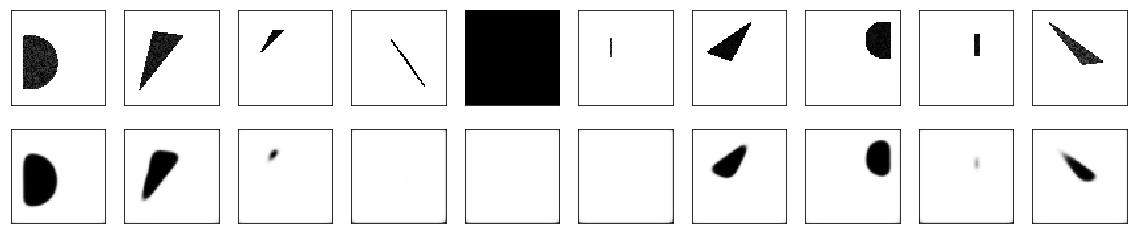

In [89]:
n = 10
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i+1)
    plt.imshow(X_test_noise[i].reshape(72, 72))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i+1 + n)
    plt.imshow(decoded_imgs[i].reshape(72, 72))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

**Comment** : The autoencoder seems to give interesting results for denoising the images. Of course going deeper in the architecture and with more epochs, we can have better results in image quality.

**END**